In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import gme
import plotly.express as px
import geopandas as gpd

plt.style.use('ggplot')
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.titlesize'] = 20

df = pd.read_csv('./data/gravity.csv', low_memory=False)
pd.options.mode.chained_assignment = None

cleaned = pd.read_csv('./data/cleaned.csv')
cleaned = cleaned[(cleaned['both_eu'] == 1) & cleaned['ltradeflow'] > 0]
cleaned['mass'] = cleaned['lgdp_o']+cleaned['lgdp_d']-cleaned['ldistw']

x = cleaned['ltradeflow']
y = cleaned['mass']

# Estimating the gravity model of trade

## Introduction: what is gravity?

- It is a model of trade first proposed in the 1950s and gained prominence from the 1990s
- The most general reduced form equation is $T_{ij}=G\cdot \frac{Y_iY_j}{D_{ij}}$, where
    - $T_{ij}$ is the tradeflow between an importer and an exporter,
    - $Y_i,Y_j$ are the GDP of the importer and exporter respectively,
    - $D_{ij}$ is the distance between the two countries,
    - $G$ is a constant.
- The model therefore represents a proportional relationship between tradeflow and mass (proxied by product of GDP divided by distance)

### Background readings
- 'The log of gravity' - Santos Silva, J and S Tenreyro (2006)
    - Used gravity equation for trade as an illustration of bias and uses PML estimation to show consistency in the presence of heteroskedasticity
    - Illustrated several forms of the gravity equation, adapted for different estimation techniques

- 'Gravity with Gravitas' - Anderson, J and van Wincoop E (2001)
    - Used the gravity equation to help solve the border puzzle
    - Re-specified the traditional gravity equation to take into account multlateral resitance term, using exporter and importer fixed effects
    
- 'Gravity Model' - Head, K and Mayer, T (2014)
    - Explained the history of the gravity model, its different specifications and methods of estimation
    - Adopted a Monte Carlo simulation to test the robustness of each gravity model and compared results to past studies in a meta analysis
    
- GME Package Documentation
    - Provided the tools and information necessary conduct PPML estimations and outlay appropriate results

- The basic gravity model works fairly well!

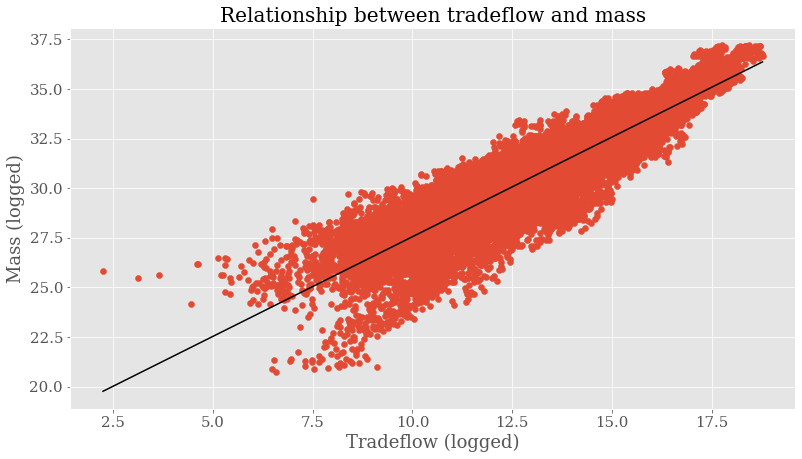

In [8]:
plt.figure(figsize=(13,7))
plt.title('Relationship between tradeflow and mass')
plt.xlabel('Tradeflow (logged)')
plt.ylabel('Mass (logged)')
plt.scatter(x,y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black')

#### But there are several issues...
- As seen in the previous graph, heteroskedasticity
- There would also be unobserved heterogeneity
    - Countries are inherently different, barring differences in measured GDP, languages, legal systems, etc.
    - There may also be heterogeneity over time
- As such, careful considerations are needed when trying to estimate elasticities in the gravity model!


## Methodology
- Given the complexity of the problem where heterogeneity may be present in 40,000 possible importer-exporter pairs, we aim to analyse the biases instead of fully correcting them
- Since we are based in the UK, we will focus on the European region

- We will therefore analyse several different regression specifications:
    - Basic gravity model: $\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\varepsilon_{ijt}$
    - Gravity model with EU dummy: $\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\delta_1both\_eu_{ijt}+\varepsilon_{ijt}$
    - Gravity model with EU dummies (to capture trade diversion): $\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\delta_1both\_eu_{ijt}+\delta_2one\_eu_{ijt}+\varepsilon_{ijt}$
    - Gravity model with all relevant regressors (to proxy for distance): $\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\delta_1both\_eu_{ijt}+\delta_2one\_eu_{ijt}+\delta_3rta_{ijt}+\delta_4same\_language_{ijt}+\cdots+\varepsilon_{ijt}$
    
    - Gravity model with all relevant regressors, and fixed effects (to capture heterogeneity): $\ln{trade_{ijt}}=\alpha_{it}+\gamma_{jt}+\xi\ln{Distance_{ijt}}+\delta_1both\_eu_{ijt}+\delta_2one\_eu_{ijt}+\delta_3rta_{ijt}+\delta_4same\_language_{ijt}+\cdots+\varepsilon_{ijt}$
- All specifications will be estimated using OLS, and some using PPML to address the likely non-linearity in the true parameters

## Data cleaning
- We use the CEPII gravity dataset published in March 2021, which contains 79 variables encompassing tradeflows, GDP, physical distance, RTA status, population, and more
- Given the choice of specifications, we first select only the variables relevant to our study

In [9]:
columns = ['year', 'iso3_o', 'iso3_d', 'distw', 'comlang_off', 'comlang_ethno', 'comcol', 'col45',
           'heg_o', 'heg_d', 'col_dep_ever', 'sibling_ever', 'gdp_o', 'gdp_d', 'wto_o', 'wto_d', 
           'eu_o', 'eu_d', 'rta', 'rta_coverage', 'tradeflow_comtrade_o', 'tradeflow_comtrade_d',
           'tradeflow_baci', 'tradeflow_imf_o', 'tradeflow_imf_d']
df = df[columns]

- The dataset contains five different measures of tradeflow, coming from various sources
- These measures differ to some extent, but they all come from credible sources (IMF, ComTrade, BACI)
- We therefore take the mean of these variables to reduce the number of missing values

In [10]:
df['tradeflow'] = df[['tradeflow_comtrade_o', 'tradeflow_comtrade_d', 'tradeflow_baci', 'tradeflow_imf_o',
                'tradeflow_imf_d']].mean(axis=1)
df = df.drop(['tradeflow_comtrade_o', 'tradeflow_comtrade_d', 'tradeflow_baci', 'tradeflow_imf_o', 
              'tradeflow_imf_d'], axis=1)

- We then construct the ```both_eu``` and ```one_eu``` dummies needed for specifications 2 and 3

In [11]:
df['both_eu'] = (df['eu_o'] == 1) & (df['eu_d'] == 1)
df['both_eu'] = df['both_eu'].astype(int)

df['one_eu'] = (((df['eu_o'] == 1) | (df['eu_d'] == 1)) & (df['both_eu'] == 0))
df['one_eu'] = df['one_eu'].astype(int)

df = df.drop(['eu_o','eu_d'], axis=1)

- We drop all observations where the importer and the exporter are the same country
- We also need to drop observations with missing regressors
- Note that for the fixed effects specification, rows with missing GDP can be kept since these get assimilated inside dummies
- We therefore create two different dataframes for the two types of specifications, ```df``` and ```df_fe```.

In [12]:
df = df.drop(df[df['iso3_o'] == df['iso3_d']].index)

df_fe = df.copy()
df_fe = df_fe.drop(df_fe[df_fe['distw'].isna()].index)

df = df.drop(df[df['gdp_o'].isna() | df['gdp_d'].isna() | df['distw'].isna()].index)

- We now consider the remaining rows that are missing the outcome variable, ```tradeflow```
- Notice that these rows are almost all belong to pairs where at least one country has extremely low GDP
- Considering the level of trade in such pairs are likely to be very low, we impute these missing data with the value of 1

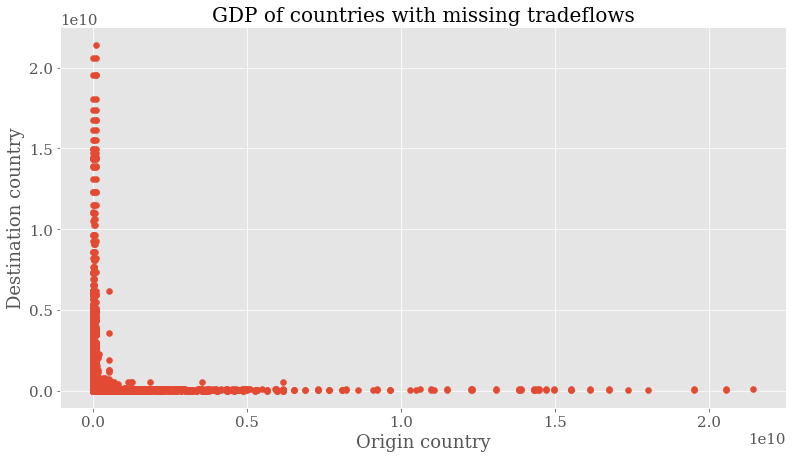

In [13]:
no_trade = df[df['tradeflow'].isna()]
plt.figure(figsize=(13,7))
plt.scatter(no_trade['gdp_o'], no_trade['gdp_d'])
plt.title('GDP of countries with missing tradeflows')
plt.xlabel('Origin country')
plt.ylabel('Destination country')
plt.show()

In [14]:
df['tradeflow'] = df['tradeflow'].fillna(1)
df_fe['tradeflow'] = df_fe['tradeflow'].fillna(1)

- For all regressors which will be log-transformed, we replace observations where these regressors have a value of 0 with 1
- We then perform the log transformation

In [15]:
df[['tradeflow', 'gdp_o', 'gdp_d', 'distw']] = df[['tradeflow', 'gdp_o', 'gdp_d', 'distw']].replace(0,1)
df_fe[['tradeflow', 'gdp_o', 'gdp_d', 'distw']] = df_fe[['tradeflow', 'gdp_o', 'gdp_d', 'distw']].replace(0,1)

df_fe[['lgdp_o','lgdp_d','ldistw','ltradeflow']] = np.log(df_fe[['gdp_o','gdp_d','distw','tradeflow']])
df_fe = df_fe.drop(['gdp_o','gdp_d','distw','tradeflow'], axis=1)

df[['lgdp_o','lgdp_d','ldistw','ltradeflow']] = np.log(df[['gdp_o','gdp_d','distw','tradeflow']])
df = df.drop(['gdp_o','gdp_d','distw','tradeflow'], axis=1)

- Finally, we noted that the only missing regressors left in the ```df``` dataframe are ```heg_o```, ```heg_d```, ```col_dep_ever```, ```sibling_ever```, between the country pairs formed by China, Hong Kong, and Taiwan
- We therefore fill in these values appropriately

In [16]:
df['heg_o'] = df['heg_o'].fillna(0)
df['heg_d'] = df['heg_d'].fillna(0)
df['col_dep_ever'] = df['col_dep_ever'].fillna(0)
df['sibling_ever'] = df['sibling_ever'].fillna(0)

- Our dataset is now cleaned and ready for analysis!

## Data Analysis
- With our focus on the European region, we create an additional dataframe containing only data within the EU

In [17]:
df1 = df.copy()
df4 = df[df['both_eu'] == 1].copy()

df1_fe = df_fe.copy()
df4_fe = df_fe[df_fe['both_eu'] == 1].copy()

### Preparing for the fixed effects regression
- Under our specification, a dummy is needed for every importer-year and exporter-year pair
- With 200 countries and 60 years, this would require 24,000 dummy variables
- Since this is extremely difficult computationally, we apply the Frisch–Waugh–Lovell Theorem and run a residual based regression instead
- This is equivalent to demeaning across both the importer-year and exporter-year dimension for both the outcome variable and regressors

- We showed that this only yields unbiased results if our data is balanced, i.e., there are no missing observations for any country pair in any year (proof omitted)
- This means double demeaning itself is not sufficient to eliminate unobserved heterogeneity 
- As such, we use repeat the demeaning process many times as bias is reduced every iteration 
    - Link to paper showing this result for anyone interested
    - https://journals.sagepub.com/doi/pdf/10.1177/1536867X1501500318

- We define a generic ```demean``` function, which takes a dataframe and two lists of dimensions
- This function demeans over both dimensions 10 times

In [18]:
def demean(df, fe1, fe2):
    data = df.copy()
    
    data['fe1'] = ''
    data['fe2'] = ''
    for column in fe1: 
        data['fe1'] += data[column].astype('str')
    for column in fe2:
        data['fe2'] += data[column].astype('str')
        
    Xys = list(set(data.columns)-set(fe1)-set(fe2)-set(['fe1','fe2']))
        
    for _ in range(10):
        data[Xys] -= data.drop('fe2', axis=1).groupby('fe1').transform('mean')[Xys]
        data[Xys] -= data.drop('fe1', axis=1).groupby('fe2').transform('mean')[Xys]
        
    data = data.drop(['fe1', 'fe2'], axis=1)
    return data

- We then apply this function to the ```df_fe``` dataframes

In [25]:
df_fe1 = demean(df_fe, ['iso3_o','year'], ['iso3_d','year'])
df_fe4 = demean(df_fe4, ['iso3_o','year'], ['iso3_d','year'])

- All dataframes are now in an appropriate and feasible form for regressions to be run
- We define a ```run_reg_ols``` and a ```run_reg_ppml``` function to aid this process

In [34]:
def run_reg_ols(Xs, dummys, full):
    X = full[Xs]
    y = full['ltradeflow']
    X = pd.concat([X, full[dummys]], axis = 1)
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    predicted_values = results.fittedvalues
    
    full['prediction'] = predicted_values
    return (full, results)

In [ ]:
all_controls = ['comlang_off', 'comlang_ethno', 'comcol', 'col45', 'heg_o', 'heg_d', 'col_dep_ever', 'sibling_ever', 'wto_o', 'wto_d', 'rta', 'both_eu', 'one_eu']
fe_controls = ['comlang_off', 'comlang_ethno', 'comcol', 'col45', 'rta', 'both_eu', 'one_eu']
eu_fe_controls = ['comlang_off', 'comlang_ethno', 'comcol', 'col45', 'rta']

In [27]:
def run_reg_ppml(dummys, full):
    full = full.reset_index()
    gme_data = gme.EstimationData(data_frame = full,
                                  imp_var_name = 'iso3_d',
                                  exp_var_name = 'iso3_o',
                                  trade_var_name = 'tradeflow',
                                  year_var_name = 'year')
    
    rhs = ['lgdp_o', 'lgdp_d', 'ldistw']
    rhs.extend(dummys)
    
    gme_model = gme.EstimationModel(estimation_data = gme_data,
                                    lhs_var = 'ltradeflow',
                                    rhs_var = rhs)

    model_estimates = gme_model.estimate()


    results = model_estimates['all']
    
    predicted_values = results.fittedvalues
    
    full['prediction'] = predicted_values
  
    return (full, results)

- We are now ready to run regressions for each of our five specifications with different subsets of the data and estimation methods!

Regression 1 (basic gravity model) using the all country pairs (OLS):
$$\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\varepsilon_{ijt}$$
    

In [28]:
res1, sum1 = run_reg_ols(Xs = ['lgdp_o', 'lgdp_d', 'ldistw'], dummys = [], full = df1)

Regression 2 (gravity model with EU dummy) using all country pairs (OLS):
$$\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\delta_1both\_eu_{ijt}+\varepsilon_{ijt}$$    

In [29]:
res2, sum2 = run_reg_ols(Xs = ['lgdp_o', 'lgdp_d', 'ldistw'], dummys = ['both_eu'], full = df1)

Regression 3 (gravity model with EU dummies to capture trade diversion) using all country pairs (OLS):
$$\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\delta_1both\_eu_{ijt}+\delta_2one\_eu_{ijt}+\varepsilon_{ijt}$$

In [30]:
res3, sum3 = run_reg_ols(Xs = ['lgdp_o', 'lgdp_d', 'ldistw'], dummys = ['both_eu', 'one_eu'], full = df1)

Regression 4 (gravity model with all relevant regressors to proxy for distance) using all country pairs (OLS):
$$\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\delta_1both\_eu_{ijt}+\delta_2one\_eu_{ijt}+\delta_3rta_{ijt}+\delta_4same\_language_{ijt}+\cdots+\varepsilon_{ijt}$$
    

In [31]:
res4, sum4 = run_reg_ols(Xs = ['lgdp_o', 'lgdp_d', 'ldistw'], dummys = all_controls, full = df1)

Regression 5 (gravity model with all relevant regressors, and fixed effects to capture heterogeneity) using all country pairs (OLS):
$$\ln{trade_{ijt}}=\alpha_{it}+\gamma_{jt}+\xi\ln{Distance_{ijt}}+\delta_1both\_eu_{ijt}+\delta_2one\_eu_{ijt}+\delta_3rta_{ijt}+\delta_4same\_language_{ijt}+\cdots+\varepsilon_{ijt}$$

In [35]:
res5, sum5 = run_reg_ols(Xs = ['ldistw'], dummys = fe_controls, full = df_fe1) 

Regression 6 (basic gravity model) using pairs within the EU (OLS):
$$\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\varepsilon_{ijt}$$

In [36]:
res6, sum6 = run_reg_ols(Xs = ['lgdp_o', 'lgdp_d', 'ldistw'], dummys = [], full = df4)

Regression 7 (gravity model with all relevant regressors to proxy for distance) using pairs within the EU (OLS):
$$\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\delta_1both\_eu_{ijt}+\delta_2one\_eu_{ijt}+\delta_3rta_{ijt}+\delta_4same\_language_{ijt}+\cdots+\varepsilon_{ijt}$$

In [37]:
res7, sum7 = run_reg_ols(Xs = ['lgdp_o', 'lgdp_d', 'ldistw'], dummys = all_controls, full = df4)

Regression 8 (gravity model with all relevant regressors, and fixed effects to capture heterogeneity) using pairs within the EU (OLS):
$$\ln{trade_{ijt}}=\alpha_{it}+\gamma_{jt}+\xi\ln{Distance_{ijt}}+\delta_1both\_eu_{ijt}+\delta_2one\_eu_{ijt}+\delta_3rta_{ijt}+\delta_4same\_language_{ijt}+\cdots+\varepsilon_{ijt}$$

In [94]:
res8, sum8 = run_reg_ols(Xs = ['ldistw'], dummys = eu_fe_controls, full = df_fe4)

Regression 9 (basic gravity model) using the all country pairs (PPML):
$$\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\varepsilon_{ijt}$$

In [39]:
res9, sum9 = run_reg_ppml(dummys = [], full = df1)

Estimation began at 09:07 PM  on Feb 25, 2022
Omitted Regressors: []
Estimation completed at 09:07 PM  on Feb 25, 2022


Regression 10 (gravity model with all relevant regressors to proxy for distance) using all country pairs (PPML):
$$\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\delta_1both\_eu_{ijt}+\delta_2one\_eu_{ijt}+\delta_3rta_{ijt}+\delta_4same\_language_{ijt}+\cdots+\varepsilon_{ijt}$$

In [40]:
res10, sum10 = run_reg_ppml(dummys = all_controls, full = df1)

Estimation began at 09:07 PM  on Feb 25, 2022
Omitted Regressors: ['col_dep_ever']
Estimation completed at 09:07 PM  on Feb 25, 2022


Regression 11 (basic gravity model) using pairs within the EU (PPML):
$$\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\varepsilon_{ijt}$$

In [41]:
res11, sum11 = run_reg_ppml(dummys = [], full = df4)

Estimation began at 09:07 PM  on Feb 25, 2022
Omitted Regressors: []
Estimation completed at 09:07 PM  on Feb 25, 2022


Regression 12 (gravity model with all relevant regressors to proxy for distance) using pairs within the EU (PPML):
$$\ln{trade_{ijt}}=G+\beta_1\ln{GDP_it}+\beta_2\ln{GDP_jt}-\xi\ln{Distance_{ijt}}+\delta_1both\_eu_{ijt}+\delta_2one\_eu_{ijt}+\delta_3rta_{ijt}+\delta_4same\_language_{ijt}+\cdots+\varepsilon_{ijt}$$

In [49]:
res12, sum12 = run_reg_ppml(dummys = list(set(all_controls)-set(['both_eu','one_eu'])), full = df4)

Estimation began at 09:19 PM  on Feb 25, 2022
Omitted Regressors: ['heg_d']
Estimation completed at 09:19 PM  on Feb 25, 2022


## Visualisation
- We now move to visualising the regression results obtained
- First some summary statistics:

In [160]:
summaries = [sum1,sum2,sum3,sum4,sum5,sum6,sum7,sum8,sum9,sum10,sum11,sum12]
params = pd.DataFrame()
for idx in list(set(sum3.params.index)-set(['const'])):
    params[idx] = [summ.params[idx] if idx in summ.params.index else 'N/A' for summ in summaries]
params.index = range(1,13)
params['R^2']= [summ.rsquared if 'rsquared' in dir(summ) else summ.pseudo_rsquared() for summ in summaries]
params = params[['R^2','ldistw','lgdp_o','lgdp_d','both_eu','one_eu']]
params

,R^2,ldistw,lgdp_o,lgdp_d,both_eu,one_eu
1,0.580426,-1.348766,0.965606,0.735371,N/A,N/A
2,0.581076,-1.311740,0.960565,0.731596,1.1346,N/A
3,0.588531,-1.251558,0.934305,0.690955,1.63803,1.05016
4,0.609178,-1.019800,0.978859,0.740608,1.25174,1.08054
5,0.136411,-1.000897,N/A,N/A,12.4872,6.3645
6,0.620193,-0.627577,1.29515,0.901758,N/A,N/A
7,0.670791,-0.824764,1.28645,0.917822,-22.9378,0
8,0.502433,-1.444369,N/A,N/A,N/A,N/A
9,0.931228,-0.439234,0.186017,0.129738,N/A,N/A
10,0.936951,-0.458253,0.189652,0.132239,-0.314187,0.193158


- Since the dataset is multidimensional, we adopt a more intuitive approach of visualising on a map
- We use ```geopandas``` and ```plotly``` to generate a choropleth map highlighting the magnitude and direction of residuals from each regression
- The function ```visualise``` is defined, which takes as parameters the name of the benchmark country (Always the UK for our purposes) and a dataframe containing all variables and a ```prediction``` column

In [100]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

def visualise(country, predicted):
    actual = predicted[predicted['iso3_d'] == country][['year','iso3_o','ltradeflow']]
    predictions = predicted[predicted['iso3_d'] == country][['year', 'iso3_o', 'prediction']]
    
    merged = pd.merge(predictions,actual,on=['year','iso3_o'],how='left')
    merged = merged.drop(merged[merged['ltradeflow'].isna()].index)
    merged['error'] = merged['prediction']-merged['ltradeflow']
    merged['error'] = merged['error']/merged['error'].std()
    merged = merged.sort_values('year', ascending=True)
    fig = px.choropleth_mapbox(merged,
        geojson=world,
        animation_frame='year',
        featureidkey='properties.iso_a3',
        locations='iso3_o',
        center={'lat':50, 'lon':0},
        color='error',
        range_color=[-3,3],
        width=950,
        height=600,
        color_continuous_scale=['darkred', 'grey', 'lime'],
        color_continuous_midpoint=0,
        mapbox_style='carto-positron',
        zoom=2)
    fig.show()

- Here are some of the more interesting maps generated from regressions 1-12:

Regression 1:

In [ ]:
visualise('GBR', res1)

Regression 4:

In [ ]:
visualise('GBR', res4)

Regression 5:

In [ ]:
visualise('GBR', res5)

Regression 10:

In [ ]:
visualise('GBR', res10)

### Some interesting observations
- Overall, errors arising from fixed effects estimation tend to be smaller in magnitude and more consistent over time
- However, fixed effects did not seem to have eliminated to country specific heterogeneity, as in all regressions trade flow with smaller countries tended to be overestimated
- There is a clear time element in all regressions (particularly ones without FE), where earlier data are underestimated and later data overestimated
- PPML overestimated EU countries while OLS did not
- A bunch of other observations, such as estimates during the collapse of USSR

## Conclusion

- In this project we explored many specifications for estimating the gravity model of trade
- We confirm the positive relationship between tradeflow and GDP, and negative relationship between tradeflow and distance, as supported by all our regression specifications
- Overall, PPML did marginally better than OLS
- Fixed effects estimation helped to eliminate some heterogeneity but not fully
- The next steps should consider the effects of time, and techniques that can be used to address bias across time and in smaller countries

## Questions?